In [1]:
from CCDPApy import CellLine    # used to aggregate all cell lines and experiments data
from CCDPApy import bioprocess_pipeline
from CCDPApy.BioProcess.BioProcess import BioProcess

input_files = ['CL1_1.xlsx', 'CL1_2.xlsx', 'CL1_3.xlsx']
measurement_sheet = 'Measured Data'
feed_sheet = 'Separate Feed Info'
poly_file = 'polynomial_order_1.xlsx'
spc = ['Glucose','Lactate','Glutamine','Asparagine','Aspartate']
new = ['new']

cell_line = CellLine()

for input in input_files:
    bp = BioProcess(file_name=input,
                    measurement_sheet=measurement_sheet,
                    feed_sheet=feed_sheet,
                    spc_list=spc,
                    #new_spc_list=new
    )
    bp.inprocess(use_feed_conc=True, use_conc_after_feed=False)
    bp.two_pt_calc()
    bp.poly_regression(polyorder_file=poly_file)
    bp.roll_regression(order=3, windows=6)

    cell_line.add_bio_process(bio_process=bp)
cell_line.disp_cell_lines()

CL1_1.xlsx imported.
CL1_2.xlsx imported.
CL1_3.xlsx imported.
Cell Line: Sample CL1
Experiment 1: Sample CL1_1
Experiment 2: Sample CL1_2
Experiment 3: Sample CL1_3


['GLUCOSE']
{'concentration': True, 'cumulative': False, 'sp_rate': False}
{'twopt': False, 'polyreg': False, 'rollreg': False}


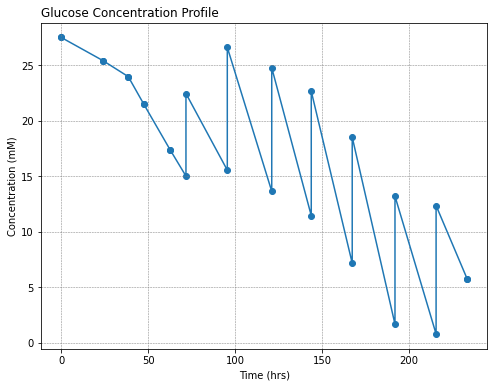

In [2]:
cl_1 = cell_line.get_cell_line(cl_name='Sample CL1')
cl1_1 = cl_1['Sample CL1_1']
fig = cl1_1.plot(spc_list='GLUCOSE', profile=['conc'])

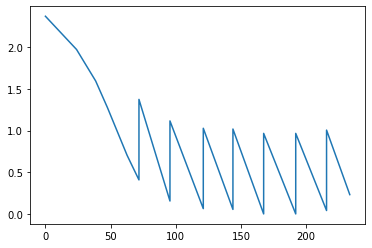

In [3]:
glt = cl1_1.get_spc_dict()['GLUTAMINE']
t = glt.get_time_hour()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conc1 = pd.concat([t, glt.get_conc_before_feed().rename('CONC.')], axis=1)
conc2 = pd.concat([t, glt.get_conc_after_feed().rename('CONC.')], axis=1)

d = pd.concat([conc1, conc2], axis=0).sort_index(kind='stable')

plt.plot('RUN TIME (HOURS)', 'CONC.', data=d)

In [4]:
glt.get_conc_df().sort_values(by='RUN TIME (HOURS)')

,Cell Line,Experiment ID,RUN TIME (HOURS),CONC.
0,Sample CL1,Sample CL1_1,0.000000,2.371408
0,Sample CL1,Sample CL1_1,0.000000,2.371408
1,Sample CL1,Sample CL1_1,23.883333,1.972562
1,Sample CL1,Sample CL1_1,23.883333,1.972562
2,Sample CL1,Sample CL1_1,38.550000,1.594671
2,Sample CL1,Sample CL1_1,38.550000,1.594671
3,Sample CL1,Sample CL1_1,47.583333,1.275137
3,Sample CL1,Sample CL1_1,47.583333,1.275137
4,Sample CL1,Sample CL1_1,62.650000,0.703307
4,Sample CL1,Sample CL1_1,62.650000,0.703307


In [ ]:
fig = cell_line.plot_cell_lines(spc_list=['glucose'], compare_cell_line=True, method='polyreg')

In [ ]:
fig = cell_line.plot_exps(cell_line='Sample CL1', spc_list=['glucose'],
                          exp_list=['Sample CL1_1'], )

In [ ]:
plot_list = ['cell', 'IgG', 'oxygen', 'glucose']
plot_list = ['alanine', 'arginine', 'glucose']
profile = ['conc', 'cumulative']
profile = 'conc'
fig = bp.plot(spc_list=plot_list, profile=profile, viability=True)

In [ ]:
plot_list = ['cell', 'IgG', 'oxygen', 'glucose']
plot_list = ['alanine', 'arginine', 'glucose']
#plot_list = 'cell'
profile = ['conc', 'cumulative']
profile = 'sp rate'
method = ['twopt', 'polyreg', 'rollreg']
fig = bp.plot(spc_list=plot_list, profile=profile, method=method)

In [ ]:
plot_list = ['cell', 'IgG', 'oxygen', 'glucose']
#plot_list = 'cell'
profile = ['conc', 'cumulative']
profile = 'cumulative'
fig = bp.plot(spc_list=plot_list, profile=profile, viability=True)

In [ ]:
spc_lst = ['cell', 'oxygen', 'igg']
bp.disp_data(exp_info=False, process='rollreg', spc='metabolite')

In [ ]:
from CCDPApy import CellLine    # used to aggregate all cell lines and experiments data
from CCDPApy import bioprocess_pipeline # used for data process of one experiment

data_file_1 = ['CL1_1.xlsx', 'CL1_2.xlsx', 'CL1_3.xlsx']
data_file_2 = ['CL2_1.xlsx', 'CL2_2.xlsx', 'CL2_3.xlsx']
data_file_3 = ['CL3_1.xlsx', 'CL3_2.xlsx', 'CL3_3.xlsx']
measurement_sheet = 'Measured Data'
feed_sheet = 'Separate Feed Info'
key_cl1 = {'use_feed_conc': True,
           'use_conc_after_feed': False,
           'spc_list': ['Glucose','Lactate','Glutamine','Asparagine','Aspartate'],
           'polyreg': True, 'polyorder_file': 'polynomial_order_1.xlsx',
           'rollreg': True, 'rollreg_order': 3, 'rollreg_window': 6,
           }

key_cl2 = {'use_feed_conc': False,
           'use_conc_after_feed': True,
           'spc_list': ['Glucose','Lactate','Glutamine','Asparagine','Aspartate'],
           'polyreg': True, 'polyorder_file': 'polynomial_order_2.xlsx',
           'rollreg': True, 'rollreg_order': 3, 'rollreg_window': 6,
           }

key_cl3 = {'use_feed_conc': False,
           'use_conc_after_feed': False,
           'spc_list': ['Glucose','Lactate','Glutamine','Asparagine','Aspartate'],
           'all_method': True
           }
cell_line = CellLine()

for input in data_file_1:
    cl_1 = bioprocess_pipeline(input_file_name=input,
                               measurement_sheet=measurement_sheet,
                               feed_sheet=feed_sheet,
                               **key_cl1)
    cell_line.add_bio_process(bio_process=cl_1)

for input in data_file_2:
    cl_2 = bioprocess_pipeline(input_file_name=input,
                               measurement_sheet=measurement_sheet,
                               feed_sheet=feed_sheet,
                               **key_cl2)
    cell_line.add_bio_process(bio_process=cl_2)


for input in data_file_3:
    cl_3 = bioprocess_pipeline(input_file_name=input,
                               measurement_sheet=measurement_sheet,
                               feed_sheet=feed_sheet,
                               **key_cl3)
    cell_line.add_bio_process(bio_process=cl_3)

In [ ]:
plot_list = plot_list = ['Glucose','Lactate','Glutamine','Asparagine','Aspartate']

method = 'twopt' # default='all', 'polyreg', 'twopt', 'rollreg' 
exp_lst = ['Sample CL2_2', 'Sample CL2_3']
file_name = 'Sample CL2'

fig = cell_line.plot_exps(cell_line='Sample CL2',
                          spc_list=plot_list,
                          method=method,
                          #exp_list=exp_lst,
                          #file_name=file_name
                          )